# Set up analysis

In [17]:
# Load modules
import datacube
import fiona
import glob
import itertools
import os
import rasterio
import rasterio.features
import xarray as xr
import numpy as np
from collections import OrderedDict
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_invalid_data
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from matplotlib import pyplot as plt
from osgeo import gdal
from shapely.geometry import Point
from shapely.geometry import shape
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

# Set up datacube instance
dc = datacube.Datacube(app = 'Random forest classification')


def load_nbart(sensor, query, bands_of_interest):
    
    '''
    Loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written 23-08-2017 based on dc v1.5.1
    '''  
    
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('Loading {}'.format(product_name))
    ds = dc.load(product = product_name,
                 measurements = bands_of_interest,
                 group_by = 'solar_day', 
                 **query)
    
    if ds:       
   
        print('Loaded {}'.format(product_name))
        
        # Extract PQ data for masking
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product = mask_product, 
                            fuse_func = ga_pq_fuser,
                            group_by = 'solar_day', 
                            **query)
        
        if sensor_pq:
            
            print('Making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca = 'no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask = 'no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous = True)
            
            # Filter to remove clouds and -999 terrain issues
            ds = ds.where(cloud_free)
            ds = ds.where(ds != -999.0)
            
            # Add projection attributes
            ds.attrs['crs'] = ds.crs
            ds.attrs['affine'] = ds.affine    
            ds.attrs['geo_transform'] = ds.geobox.transform.to_gdal()
            ds.attrs['proj'] = ds.geobox.crs.wkt
            print('Masked {} with {} and filtered' \
                  'terrain'.format(product_name, mask_product))
            
        else: 
            
            print('Did not mask {} with {}'.format(product_name, mask_product))
            
    else:
        
        print ('Did not load {}'.format(product_name)) 

    if len(ds) > 0:
        
        return ds
    
    else:
        
        return None


def rasterize_vector(input_data, cols, rows, geo_transform,
                     projection, field):
    
    """
    Rasterize a vector file and return numpy array
    :attr input_data: input shapefile path or preloaded GDAL/OGR layer
    :attr cols: width of output array in columns
    :attr rows: height of output array in rows
    :attr geo_transform: geotransform for rasterization
    :attr projection: projection for rasterization
    :attr field: shapefile field to take values from
    :returns: a 'row x col' array containg values from vector
    """
    
    # If input data is a string, import as shapefile layer
    if isinstance(input_data, str):    
    
        # Open vector with gdal
        data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
        input_data = data_source.GetLayer(0)
    
    # Set up output raster
    driver = gdal.GetDriverByName('GTiff')  # 'MEM')  # In memory dataset
    target_ds = driver.Create('test.tif', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    
    # Rasterize shapefile and extract array
    gdal.RasterizeLayer(target_ds, [1], input_data, options=["ATTRIBUTE=" + field])
    band = target_ds.GetRasterBand(1)
    out_array = band.ReadAsArray()
    target_ds = None
    
    return out_array


def write_geotiff(fname, data, geo_transform, projection, nodata_val):
    
    """
    Create a single band GeoTIFF file with data from array.
    :attr fname: output file path
    :attr data: input array
    :attr geo_transform: geotransform for output raster
    :attr projection: projection for output raster
    :attr nodata_val: value to convert to nodata in output raster
    """
    
    # Set up driver
    driver = gdal.GetDriverByName('GTiff')
    
    # Create raster of given size and projection
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    
    # Write data to array and set nodata values
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    band.SetNoDataValue(nodata_val)
    
    # Close file
    dataset = None  
    
    
def hltc_import(query):
    
    """
    Imports high and low composite data for a given spatial query, and
    return an xarray dataset with projection and geo transform attributes
    :attr query: spatial query for datacube.load()
    :returns: xarray dataset with geo transform and projection attributes
    """

    # Import data
    low_tide = dc.load(product = 'low_tide_comp_20p', **query)
    high_tide = dc.load(product = 'high_tide_comp_20p', **query)

    # Rename variables in each high/low composite so datasets can be merged
    data_vars = list(low_tide.keys())[3:]  # select only data vars, not coords
    low_tide.rename({var: "lt_" + var for var in data_vars}, inplace = True)
    high_tide.rename({var: "ht_" + var for var in data_vars}, inplace = True)

    # Combine into one dataset
    output_xarray = xr.auto_combine([low_tide, high_tide]).isel(time = 0)
    
    # Set attributes   
    output_xarray.attrs['proj'] = low_tide.geobox.crs.wkt
    output_xarray.attrs['geo_transform'] = low_tide.geobox.transform.to_gdal()    
    
    return output_xarray


def tasseled_cap(sensor_data, sensor, tc_bands = ['greenness', 'brightness', 'wetness'], 
                 drop = True):
    
    """
    Computes tasseled cap wetness, greenness and brightness bands from a six
    band xarray dataset, and returns a new xarray dataset with old bands 
    optionally dropped
    :attr sensor_data: input xarray dataset with six Landsat bands
    :attr tc_bands: list of tasseled cap bands to compute 
    (valid options: 'wetness', 'greenness','brightness'
    :attr sensor: Landsat sensor used for coefficient values 
    (valid options: 'ls5', 'ls7', 'ls8')
    :attr drop: if 'drop = False', return all original Landsat bands 
    :returns: xarray dataset with newly computed tasseled cap bands
    """
    
    # Copy input dataset
    output_array = sensor_data.copy(deep = True)
 
    # Coefficients for each tasseled cap band
    wetness_coeff = {'ls5':{'blue':0.0315, 'green':0.2021, 'red':0.3102, 
                            'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109},
                     'ls7':{'blue':0.0315, 'green':0.2021, 'red':0.3102, 
                            'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109},
                     'ls8':{'blue':0.0315, 'green':0.2021, 'red':0.3102, 
                            'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109}}
    
    greenness_coeff = {'ls5':{'blue':-0.1603, 'green':-0.2819, 'red':-0.4934, 
                              'nir':0.7940, 'swir1':-0.0002, 'swir2':-0.1446},
                       'ls7':{'blue':-0.1603, 'green':-0.2819, 'red':-0.4934, 
                              'nir':0.7940, 'swir1':-0.0002, 'swir2':-0.1446},
                       'ls8':{'blue':-0.1603, 'green':-0.2819, 'red':-0.4934, 
                              'nir':0.7940, 'swir1':-0.0002, 'swir2':-0.1446}}
    
    brightness_coeff = {'ls5':{'blue':0.2043, 'green':0.4158, 'red':0.5524, 
                               'nir':0.5741, 'swir1':0.3124, 'swir2':0.2303},
                        'ls7':{'blue':0.2043, 'green':0.4158, 'red':0.5524, 
                               'nir':0.5741, 'swir1':0.3124, 'swir2':0.2303},
                        'ls8':{'blue':0.2043, 'green':0.4158, 'red':0.5524, 
                               'nir':0.5741, 'swir1':0.3124, 'swir2':0.2303}}
    
    # Dict to use correct coefficients for each tasseled cap band
    analysis_coefficient = {'wetness': wetness_coeff, 
                            'greenness': greenness_coeff,
                            'brightness': brightness_coeff}
    
    # For each band, compute tasseled cap band and add to output dataset
    for tc_band in tc_bands:

        # Create xarray of coefficient values used to multiply each band of input
        coeff = xr.Dataset(analysis_coefficient[tc_band][sensor])    
        sensor_coeff = sensor_data * coeff

        # Sum all bands
        output_array[tc_band] = sensor_coeff.blue + sensor_coeff.green + \
                                sensor_coeff.red + sensor_coeff.nir + \
                                sensor_coeff.swir1 + sensor_coeff.swir2
    
    # If drop = True, remove original bands
    if drop:
        
        bands_to_drop = list(sensor_data.data_vars)        
        output_array = output_array.drop(bands_to_drop)        

    return(output_array)


def point_in_poly(lon, lat, field, shapefile):
    
    """
    Extract data from polygon that contains point
    :attr lon: x coordinate of point
    :attr lat: y coordinate of point
    :attr field: field of polygon shapefile to extract for matching points
    :attr shapefile: polygon shapefile to import
    :returns: if point falls within polygon, return field from polygon
    """

    # Convert coordinates to shapely point
    mypoint = Point(lon, lat)   

    # Extract polygon info
    with fiona.open(shapefile) as shp:

        # For each polygon, identify if point falls within polygon
        poly_idx = [poly['properties']['ID'] for i, poly in enumerate(shp)
                    if mypoint.within(shape(poly['geometry']))]

    # If point is within polygon
    if poly_idx:
        
        # Take first polygon to avoid multiple matches        
        return(poly_idx[0])

    # If point not found in any polygon, return none
    else: 
        
        return None


def layer_extent(layer):
    
    """
    Computes min and max extents for GDAL layer features. Compared to
    built-in ".GetExtent" that always returns unfiltered extents, this 
    allows you to compute extents of features within filtered layers 
    (e.g. layers filtered with 'SetAttributeFilter')
    """
    
    # Extract tuples of x, y, z coordinates for each point feature
    point_coords = [feature.geometry().GetPoint() for feature in layer]
    
    # Compute mins and maxes across points for each tuple element
    max_x, max_y, max_z = map(min, zip(*point_coords))
    min_x, min_y, min_z = map(max, zip(*point_coords))    
    
    return  min_x, max_x, min_y, max_y


# Set up paths
classification_output = "output_data/classification_dc_hltc_mangroves.tiff"
train_data_path = "raw_data/train"
# validation_data_path = "raw_data/test"


# Experiment with TC indices

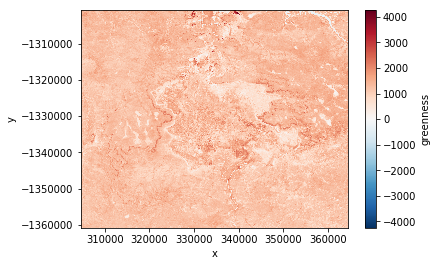

In [24]:
# Set up analysis data query
lat_point, lon_point, buffer = -12.5760601941, 135.026655065, 30000
x, y = geometry.point(lon_point, lat_point, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]

# Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     'swir2']

# Set up query
query = {'time': ('2017-03-01', '2017-06-28'),
         'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),
         'crs': 'EPSG:3577'}

# Test function
nbar_example = load_nbart('ls8',query,bands_of_interest)
out = tasseled_cap(sensor_data = nbar_example, 
                   tc_bands = ['greenness', 'brightness', 'wetness'], 
                   sensor = 'ls8',
                   drop = True)

# Plot
out.median("time").greenness.plot()


# Import training data and fit model

In [ ]:
# Iterate through each point and extract matching polygon data
with fiona.open(train_data_path + "/training_data_mangrove.shp") as points:
        
        # Output IDs
        poly_ids = list()
        
        # For each point, identify what polygon it belongs to        
        for point in points:
            
            # Convert albers coordinates to WGS84    
            lon, lat = point['geometry']['coordinates']        
            x, y = geometry.point(lon, lat, CRS('EPSG:3577')).to_crs(CRS('WGS84')).points[0]
            
            poly_id = point_in_poly(lon = x, lat = y, field = 'ID',
                                    shapefile = '/g/data/r78/intertidal/GA_native_tidal_model.shp')
            
            poly_ids.append(poly_id)

# Open vector of training points with gdal
data_source = gdal.OpenEx(train_data_path + "/training_data_mangrove.shp", gdal.OF_VECTOR)
layer = data_source.GetLayer(0)

# Output training label and pixel arrays
training_labels_list = list()
training_samples_list = list()

# For each polygon, extract datacube data using extent of matching points
# and add resulting spectral data and labels to list of arrays
for polygon_id in set(poly_ids):
    
    print("Extracting training data for polygon {}".format(polygon_id))

    # List of matching FIDs
    fid_list = [i for i, x in enumerate(poly_ids) if x == polygon_id]    

    # Temporary fix for polygons containing only one training point: setAttributeFilter
    # returns all polygons if passed a single element tuple, so duplicate the single FID
    if len(fid_list) == 1:  
        fid_list = [fid_list[0], fid_list[0]]     
        
    # Filter layer by passing list of FIDs to SQL query as tuple, i.e. "(1, 2, ...)"
    layer.SetAttributeFilter("FID IN {}".format(tuple(fid_list)))        
        
    # Compute extents and generate spatial query
    xmin, xmax, ymin, ymax = layer_extent(layer) 
    query_train = {'x': (xmin, xmax),
                   'y': (ymin, ymax),
                   'crs': 'EPSG:3577'}

    # Import data  as xarray and extract projection/transform data
    training_xarray = hltc_import(query_train)
    geo_transform_train = training_xarray.geo_transform
    proj_train = training_xarray.proj 
    
    # Covert to array and rearrange dimension order
    bands_array_train = training_xarray.to_array().values
    bands_array_train = np.einsum('bxy->xyb', bands_array_train)
    rows_train, cols_train, bands_n_train = bands_array_train.shape

    # Import training data shapefiles and convert to matching raster pixels
    training_shapefile = train_data_path + "/training_data_mangrove.shp"
    training_pixels = rasterize_vector(layer, cols_train, rows_train, 
                                       geo_transform_train, proj_train, field = "class")  
    
    # Extract matching image sample data for each labelled pixel location
    is_train = np.nonzero(training_pixels)
    training_labels = training_pixels[is_train]
    training_samples = bands_array_train[is_train]

    # Remove nans from training samples
    training_labels = training_labels[~np.isnan(training_samples).any(axis=1)]
    training_samples = training_samples[~np.isnan(training_samples).any(axis=1)]
    
    # Append outputs
    training_labels_list.append(training_labels)
    training_samples_list.append(training_samples)

# Combine polygon training data    
training_labels = np.concatenate(training_labels_list, axis=0)
training_samples = np.concatenate(training_samples_list, axis=0)  

# Set up classifier and train on training sample data and labels
# Options for tuning: https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
print("\nTraining random forest classifier...")
classifier = RandomForestClassifier(n_jobs = -1,                                    
                                    n_estimators = 100,
                                    max_features = "log2",  # auto, sqrt, log2
                                    min_samples_leaf = 3,
                                    oob_score = True) 
classifier.fit(training_samples, training_labels)
print("Model trained on {} training samples".format(str(len(training_samples))))


# Import HLTC analysis data and prepare for classification

In [ ]:
# Set up analysis data query
lat_point, lon_point, buffer = -12.4820331618, 130.91288064, 30000
x, y = geometry.point(lon_point, lat_point, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),
         'crs': 'EPSG:3577'}

# Import data  as xarray and extract projection/transform data
analysis_xarray = hltc_import(query)
geo_transform = analysis_xarray.geo_transform
proj = analysis_xarray.proj 

# Covert to array and rearrange dimension order
analysis_array = analysis_xarray.to_array().values
analysis_array = np.einsum('bxy->xyb', analysis_array)
rows, cols, bands_n = analysis_array.shape
print("Data to classify:\nRows: {0}\nColumns: {1}\nBands: {2}".format(rows, cols, bands_n))

# Remove nodata and return flattened 'pixel x bands' array
input_nodata = np.isnan(analysis_array).any(axis = 2)
flat_pixels = analysis_array[~input_nodata]


# Run analysis

In [ ]:
# Set up paths
classification_output = "output_data/classification_dc_hltc_mangroves2.tiff"

# Run classification
print("Classification running...")
result = classifier.predict(flat_pixels)

# Restore 2D array by assigning flattened output to empty array
classification = np.zeros((rows, cols))
classification[~input_nodata] = result
print("  Classification complete")

# Nodata removed
print("  " + str(np.sum(classification == 0)) + " nodata cells removed")

# Export to file
write_geotiff(classification_output, 
              data = classification, 
              geo_transform = geo_transform, 
              projection = proj,
              nodata_val = 0)
print("    Classification exported")


# Test classifier parameters

In [ ]:
# # Plot output random forest trees to file
# for n, tree_in_forest in enumerate(classifier.estimators_):

#     # Create graph and save to dot file
#     export_graphviz(tree_in_forest,
#                     out_file="figures/tree_graphs/tree.dot",
#                     feature_names = list(training_xarray.keys())[3:],
#                     class_names = ["mangrove", "water", "veg", "other"],
#                     filled=True,
#                     rounded=True)

#     # Plot as figure
#     os.system('dot -Tpng figures/tree_graphs/tree.dot -o ' + \
#               'figures/tree_graphs/tree' + str(n + 1) + '.png')

# # NOTE: Setting the `warm_start` construction parameter to `True` disables
# # support for parallelized ensembles but is necessary for tracking the OOB
# # error trajectory during training.

# # Test scenarios
# ensemble_clfs = [("max_features='sqrt'",
#                   RandomForestClassifier(warm_start=True, oob_score=True,
#                                          max_features="sqrt")),
#                  ("max_features='0.5'",
#                   RandomForestClassifier(warm_start=True, max_features=0.5,
#                                          oob_score=True)),
#                  ("max_features=None",
#                   RandomForestClassifier(warm_start=True, max_features=None,
#                                          oob_score=True))]

# ensemble_clfs = [("Leaf = 1",
#                   RandomForestClassifier(warm_start=True, 
#                                          min_samples_leaf = 1,
#                                          oob_score=True)),
#                  ("Leaf = 5",
#                   RandomForestClassifier(warm_start=True, 
#                                          min_samples_leaf = 5,
#                                          oob_score=True)),
#                  ("Leaf = 20",
#                   RandomForestClassifier(warm_start=True, 
#                                          min_samples_leaf = 20,
#                                          oob_score=True))]

# # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
# error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# # Range of `n_estimators` values to explore.
# min_estimators = 1
# max_estimators = 100

# for label, clf in ensemble_clfs:
#     for i in range(min_estimators, max_estimators + 1):
#         clf.set_params(n_estimators=i)
#         clf.fit(training_samples, training_labels)

#         # Record the OOB error for each `n_estimators=i` setting.
#         oob_error = 1 - clf.oob_score_
#         error_rate[label].append((i, oob_error))

# # Generate the "OOB error rate" vs. "n_estimators" plot.
# for label, clf_err in error_rate.items():
#     xs, ys = zip(*clf_err)
#     plt.plot(xs, ys, label=label)

# plt.xlim(min_estimators, max_estimators)
# plt.xlabel("n_estimators")
# plt.ylabel("OOB error rate")
# plt.legend(loc="upper right")
# plt.show()


# Classification statistics

In [ ]:
# # Verification data
# shapefiles = glob.glob(validation_data_path + "/*.shp")
# classes = [i.split("/")[2][0:1] for i in shapefiles]
# verification_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
# for_verification = np.nonzero(verification_pixels)
# verification_labels = verification_pixels[for_verification]
# predicted_labels = classification[for_verification]

# # Confusion matrix
# print("Confussion matrix:\n%s" %
#       metrics.confusion_matrix(verification_labels, predicted_labels))
# target_names = ['Class %s' % s for s in classes]

# # Per class report
# print("Classification report:\n%s" %
#       metrics.classification_report(verification_labels, predicted_labels,
#                                     target_names=target_names))

# # Overall classification accuracy
# print("Classification accuracy: %f" %
#       metrics.accuracy_score(verification_labels, predicted_labels))

# Old import NBAR from datacube

In [ ]:
# # Define temporal range
# start_of_epoch, end_of_epoch = '2015-01-01', '2015-03-01'

# # Define wavelengths/bands of interest
# bands_of_interest = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']


# # Define sensor of interest
# sensor1 = 'ls8'

# # Location
# lat_point, lon_point, buffer = -31.88, 152.69, 30000
# x, y = geometry.point(lon_point, lat_point, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]

# # Set up query
# query = {'time': (start_of_epoch, end_of_epoch)}
# query['x'] = (x - buffer, x + buffer)
# query['y'] = (y - buffer, y + buffer)
# query['crs'] = 'EPSG:3577'
# print(query)

# # Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
# pq_albers_product = dc.index.products.get_by_name(sensor1 + '_pq_albers')
# valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

# # Load sensor specific band adjustment tuples for TSS 
# # ls5_tss_constant, ls5_tss_exponent = 3983, 1.6246
# # ls7_tss_constant, ls7_tss_exponent = 3983, 1.6246
# # ls8_tss_constant, ls8_tss_exponent = 3957, 1.6436   

# # Retrieve the NBAR and PQ data for sensor n
# sensor1_nbar = dc.load(product = sensor1 + '_nbar_albers', 
#                        group_by = 'solar_day', 
#                        measurements = bands_of_interest,  
#                        **query)
# sensor1_pq = dc.load(product = sensor1 + '_pq_albers', 
#                      group_by = 'solar_day', 
#                      fuse_func = pq_fuser, 
#                      **query)

# # Extract projection information
# crs = sensor1_nbar.crs.wkt
# affine = sensor1_nbar.affine

# # Ensure 1:1 match between NBAR and PQ
# sensor1_nbar = sensor1_nbar.sel(time = sensor1_pq.time)

# # Generate PQ masks and apply to remove cloud, cloud shadow and saturated observations
# s1_cloud_free = masking.make_mask(sensor1_pq,
#                                   cloud_acca = 'no_cloud',
#                                   cloud_shadow_acca = 'no_cloud_shadow',
#                                   cloud_shadow_fmask = 'no_cloud_shadow',
#                                   cloud_fmask = 'no_cloud',
#                                   blue_saturated = False,
#                                   green_saturated = False,
#                                   red_saturated = False,
#                                   nir_saturated = False,
#                                   swir1_saturated = False,
#                                   swir2_saturated = False,
#                                   contiguous = True)

# # Extract good data
# s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
# sensor1_nbar = sensor1_nbar.where(s1_good_data)
# sensor1_nbar

# # Single clear timestep 6 (time 2015-02-28T23:43:05)
# raster_input = sensor1_nbar.isel(time = 6)
# raster_input.red.plot()

# # Write data to file
# write_multibandgeotiff(filename="raw_data/input_raster.tif", dataset=raster_input) 
